In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import re


In [12]:
df_covid = pd.read_csv("data/brazil_covid19_cities.csv")  

In [13]:
df_covid.head()

,date,state,name,code,cases,deaths
0,2020-03-27,AC,Acrelândia,120001.0,0.0,0
1,2020-03-27,AC,Assis Brasil,120005.0,0.0,0
2,2020-03-27,AC,Brasiléia,120010.0,0.0,0
3,2020-03-27,AC,Bujari,120013.0,0.0,0
4,2020-03-27,AC,Capixaba,120017.0,0.0,0


## Limpeza de dados

In [14]:
# renomear coluna name para city
df_covid = df_covid.rename(columns={'name': 'city'})
df_covid

,date,state,city,code,cases,deaths
0,2020-03-27,AC,Acrelândia,120001.0,0.0,0
1,2020-03-27,AC,Assis Brasil,120005.0,0.0,0
2,2020-03-27,AC,Brasiléia,120010.0,0.0,0
3,2020-03-27,AC,Bujari,120013.0,0.0,0
4,2020-03-27,AC,Capixaba,120017.0,0.0,0
...,...,...,...,...,...,...
2356105,2021-05-23,TO,Tocantinópolis,172120.0,1968.0,41
2356106,2021-05-23,TO,Tupirama,172125.0,143.0,2
2356107,2021-05-23,TO,Tupiratins,172130.0,80.0,1
2356108,2021-05-23,TO,Wanderlândia,172208.0,772.0,11


In [15]:
df_covid['date'] = pd.to_datetime(df_covid['date'])
df_covid = df_covid.sort_values(['city', 'date'])

# Garantir que casos e mortes são numéricos
df_covid['cases'] = pd.to_numeric(df_covid['cases'], errors='coerce')
df_covid['deaths'] = pd.to_numeric(df_covid['deaths'], errors='coerce')

df_covid = df_covid.dropna(subset=['city', 'cases', 'deaths'])

In [17]:
# Criar VARIÁVEIS POR CIDADE E ESTADO
features_city = df_covid.groupby(['city', 'state']).agg({

    'cases': ['max', 'mean', 'std'],
    'deaths': ['max', 'mean', 'std'],
    'date': 'count'

})

features_city.columns = [
    'total_cases',
    'mean_cases',
    'std_cases',
    'total_deaths',
    'mean_deaths',
    'std_deaths',
    'days_recorded'
]

features_city.head()

,,total_cases,mean_cases,std_cases,total_deaths,mean_deaths,std_deaths,days_recorded
city,state,,,,,,,
Abadia de Goiás,GO,1351.0,558.153664,426.181817,28,7.565012,7.530658,423
Abadia dos Dourados,MG,375.0,118.761229,119.465862,14,2.687943,4.138253,423
Abadiânia,GO,400.0,147.659574,105.898626,27,10.801418,8.029761,423
Abaetetuba,PA,7659.0,3646.444444,2098.725146,210,104.628842,48.581654,423
Abaeté,MG,1019.0,248.574468,312.806079,26,5.224586,6.855251,423


In [18]:
# taxa de mortalidade
features_city['death_rate'] = (
    features_city['total_deaths'] / features_city['total_cases']
)

In [19]:
# Crescimento dos casos
df_covid['new_cases'] = df_covid.groupby(['city', 'state'])['cases'].diff().fillna(0)

growth = df_covid.groupby(['city', 'state'])['new_cases'].mean().rename('mean_daily_growth')
features_city = features_city.join(growth)

In [20]:
# Dia do primeiro caso
first_case = df_covid[df_covid['cases'] > 0].groupby(['city','state'])['date'].min()
first_case = (first_case - df_covid['date'].min()).dt.days
first_case = first_case.rename('days_until_first_case')

features_city = features_city.join(first_case)


In [21]:
features_city = features_city.dropna()
features_city = features_city.reset_index()
features_city


,city,state,total_cases,mean_cases,std_cases,total_deaths,mean_deaths,std_deaths,days_recorded,death_rate,mean_daily_growth,days_until_first_case
0,Abadia de Goiás,GO,1351.0,558.153664,426.181817,28,7.565012,7.530658,423,0.020725,3.193853,55
1,Abadia dos Dourados,MG,375.0,118.761229,119.465862,14,2.687943,4.138253,423,0.037333,0.886525,42
2,Abadiânia,GO,400.0,147.659574,105.898626,27,10.801418,8.029761,423,0.067500,0.945626,63
3,Abaetetuba,PA,7659.0,3646.444444,2098.725146,210,104.628842,48.581654,423,0.027419,18.106383,4
4,Abaeté,MG,1019.0,248.574468,312.806079,26,5.224586,6.855251,423,0.025515,2.408983,16
...,...,...,...,...,...,...,...,...,...,...,...,...
5565,Áurea,RS,202.0,53.307329,58.444733,3,0.754137,1.095478,423,0.014851,0.477541,51
5566,Ângulo,PR,283.0,88.886525,90.399673,6,1.465721,1.509255,423,0.021201,0.669031,60
5567,Érico Cardoso,BA,235.0,60.338061,81.674372,2,0.846336,0.955170,423,0.008511,0.555556,75
5568,Óbidos,PA,6049.0,2496.177305,1930.441608,112,42.179669,32.105806,423,0.018515,14.300236,19


In [22]:
# Removendo colunas nao numericas
features_city_numeric = features_city.select_dtypes(include=[np.number])

# Normalização

In [23]:
# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_city_numeric)

## Redução de dimensionalidade - PCA


In [30]:
# Inicializando a PCA sem redução para analisar um panorama inicial
pca_full = PCA()
pca_full.fit(X_scaled)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(X_scaled)

(5570, 2)

In [31]:
# Calculando a variancia explicada acumulada
variancia_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

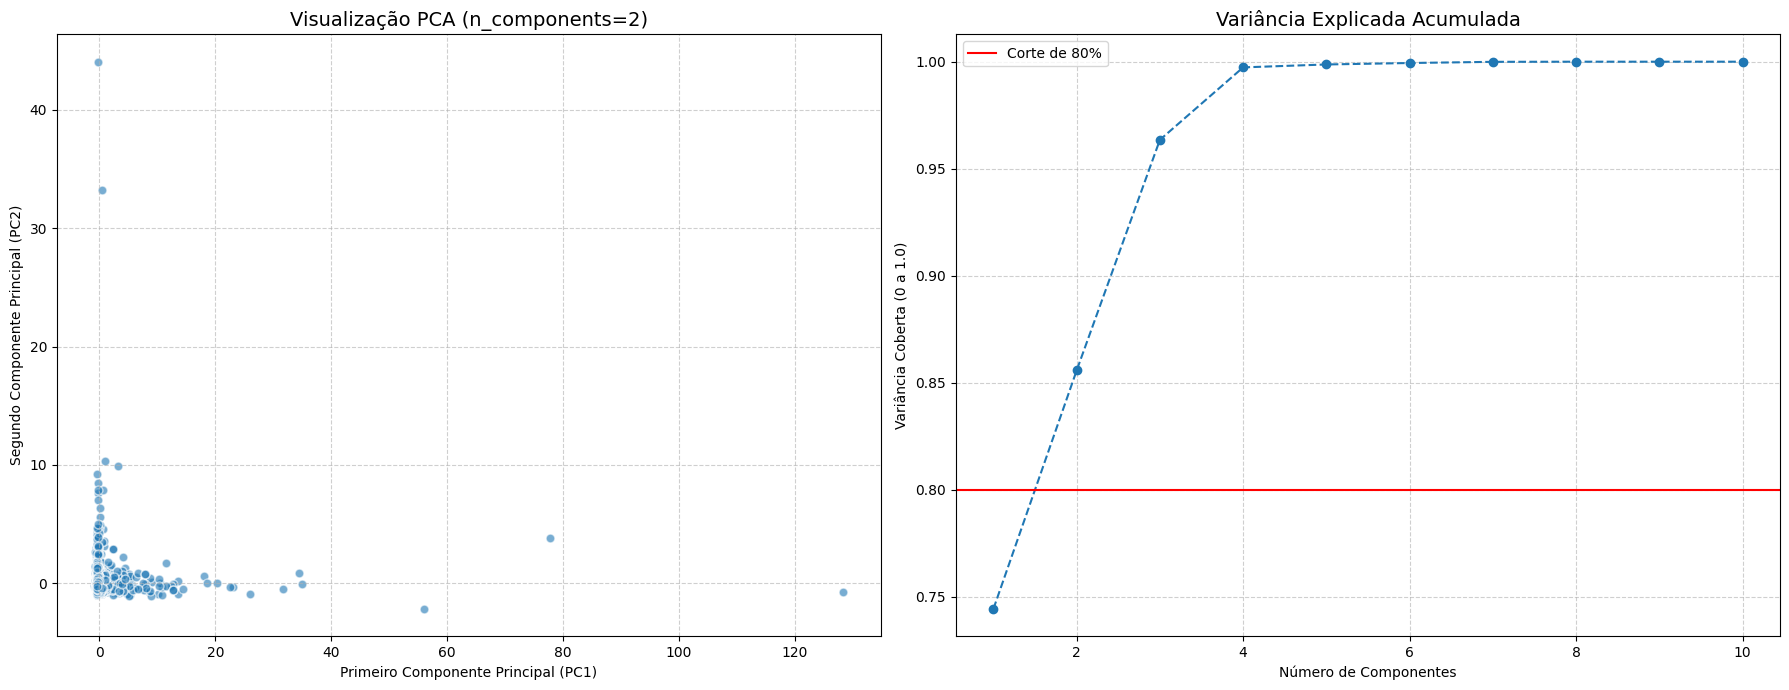

Variância Total com 2 componentes: 85.57%


In [32]:
# Criando a moldura com 1 linha e 2 colunas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Visualização PCA 
ax1.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.6, edgecolors='w', s=40)
ax1.set_title('Visualização PCA (n_components=2)', fontsize=14)
ax1.set_xlabel('Primeiro Componente Principal (PC1)')
ax1.set_ylabel('Segundo Componente Principal (PC2)')
ax1.grid(True, linestyle='--', alpha=0.6)

# Vizualização da Variância
ax2.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
ax2.axhline(y=0.80, color='r', linestyle='-', label='Corte de 80%') # Linha de corte
ax2.set_title('Variância Explicada Acumulada', fontsize=14)
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Variância Coberta (0 a 1.0)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

# Ajustando o layout para não sobrepor
plt.tight_layout()
plt.show()

# Print informativo
print(f"Variância Total com 2 componentes: {variancia_acumulada[1]:.2%}")

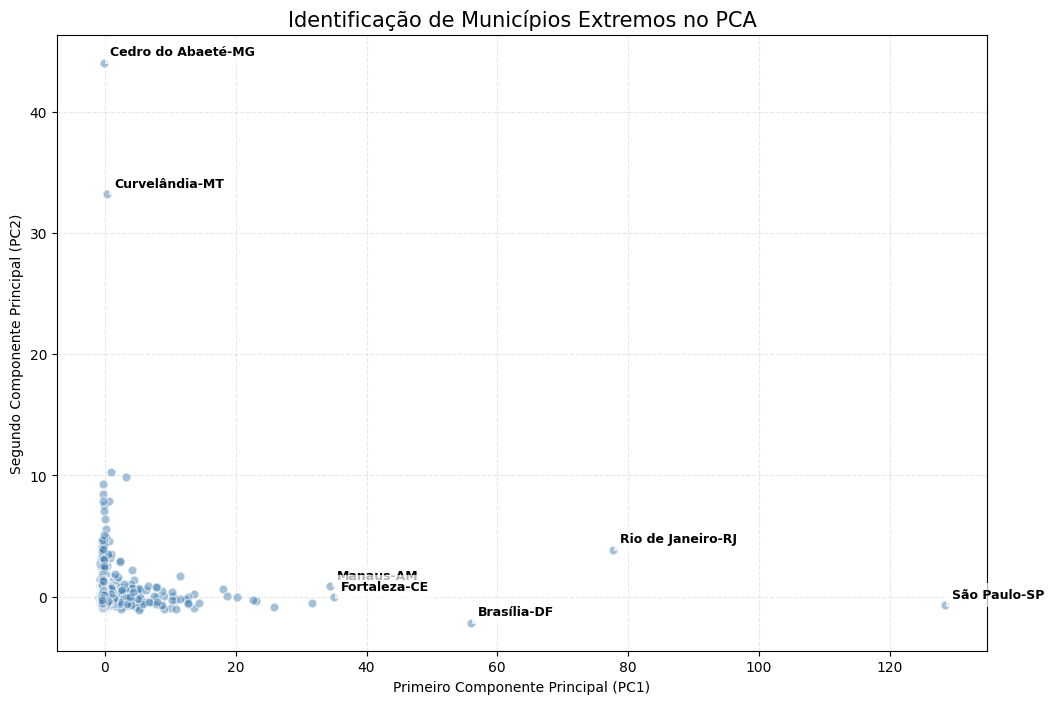

In [33]:
import numpy as np

plt.figure(figsize=(12, 8))

plt.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.5, edgecolors='w', s=40, color='steelblue')

# Calculando a distância de cada ponto em relação à origem (0,0) do PCA
distancias = np.sqrt(df_pca[:, 0]**2 + df_pca[:, 1]**2)

# Pegandos os índices das 7 cidades mais distantes
indices_extremos = np.argsort(distancias)[-7:]

# Adicionando os rótulos apenas para essas cidades
for idx in indices_extremos:
    # features_city é o DataFrame original que contém os nomes
    cidade = features_city.iloc[idx]['city']
    estado = features_city.iloc[idx]['state']
    
    plt.annotate(f"{cidade}-{estado}", 
                 (df_pca[idx, 0], df_pca[idx, 1]),
                 textcoords="offset points", 
                 xytext=(5,5), 
                 fontsize=9, 
                 fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('Identificação de Municípios Extremos no PCA', fontsize=15)
plt.xlabel('Primeiro Componente Principal (PC1)')
plt.ylabel('Segundo Componente Principal (PC2)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

## Redução de dimensionalidade - t-SNE

In [34]:
# Definindo as preplexidades para teste
perplexidades = [20, 30, 50]

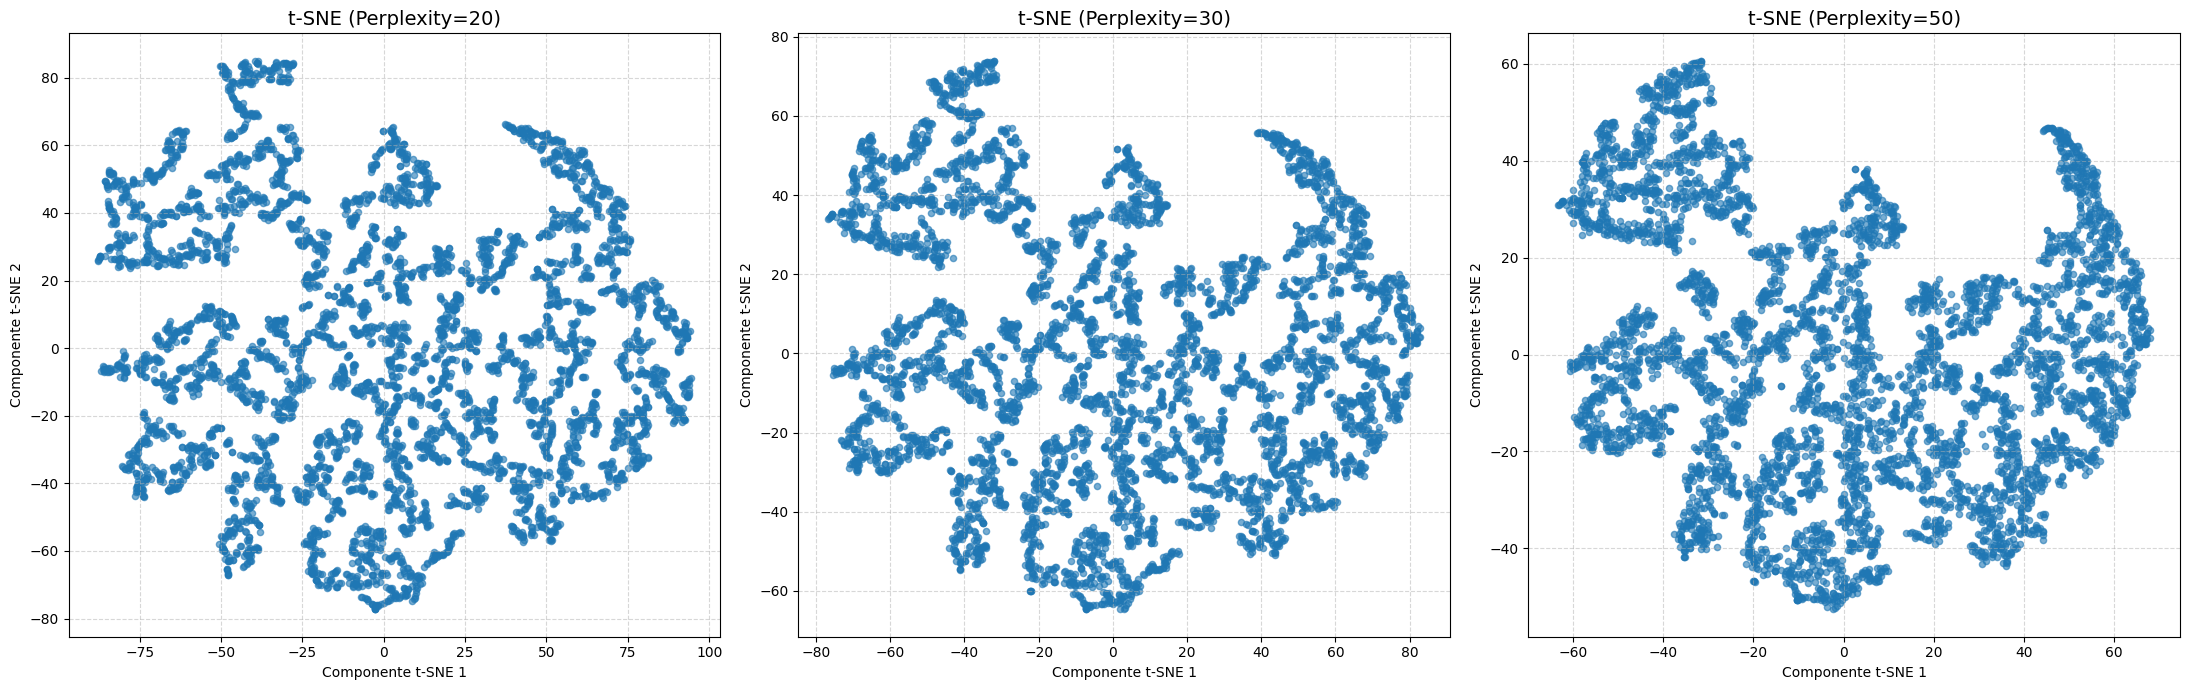

In [36]:
# Criando muldura para as imagnes 
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

for i, perp in enumerate(perplexidades):
    # Aplicando o t-SNE (usamos random_state para resultados reproduzíveis)
    tsne = TSNE(n_components=2, perplexity=perp, max_iter=1000, learning_rate=200, random_state=42)
    df_tsne = tsne.fit_transform(X_scaled)
    
    # Plotando no subplot correspondente (axes[i])
    axes[i].scatter(df_tsne[:, 0], df_tsne[:, 1], alpha=0.6, s=20)
    axes[i].set_title(f't-SNE (Perplexity={perp})', fontsize=14)
    axes[i].set_xlabel('Componente t-SNE 1')
    axes[i].set_ylabel('Componente t-SNE 2')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ajusta o espaçamento para os títulos não cortarem
plt.tight_layout()
plt.show()

In [38]:
# Criando a estrutura de subplots 3D (1 linha, 3 colunas)
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=[f't-SNE (Perplexity={p})' for p in perplexidades]
)

for i, perp in enumerate(perplexidades):
    # IMPORTANTE: n_components=3
    tsne = TSNE(n_components=3, perplexity=perp, random_state=42, n_jobs=-1)
    X_tsne_3d = tsne.fit_transform(X_scaled)
    
    # Adicionando os pontos ao gráfico
    fig.add_trace(
        go.Scatter3d(
            x=X_tsne_3d[:, 0],
            y=X_tsne_3d[:, 1],
            z=X_tsne_3d[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=labels, # Suas cores dos clusters do K-Means
                colorscale='Viridis',
                opacity=0.5
            ),
            name=f'Perp {perp}'
        ),
        row=1, col=i+1
    )

# Ajustando o layout
fig.update_layout(
    height=700,
    title_text='Comparação t-SNE 3D: Efeito da Perplexidade',
    showlegend=False
)

# Gente, caso nao apareca no seu notebook, descomente a linha abaixo para abrir no navegador
# import plotly.io as pio
# pio.renderers.default = "browser"

fig.show()

NameError: name 'make_subplots' is not defined

## Redução de dimensionalidade - UMAP

In [39]:
vizinhos = [15, 30, 100]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/yb/0t_199hd6xd0c8zshql8663w0000gn/T/ipykernel_5221/3865516290.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axes[i].scatter(df_umap[:, 0], df_umap[:, 1], alpha=0.6, s=15, cmap='viridis')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/yb/0t_199hd6xd0c8zshql8663w0000gn/T/ipykernel_5221/3865516290.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axes[i].scatter(df_umap[:, 0], df_umap[:, 1], alpha=0.6, s=15, cmap='viridis')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

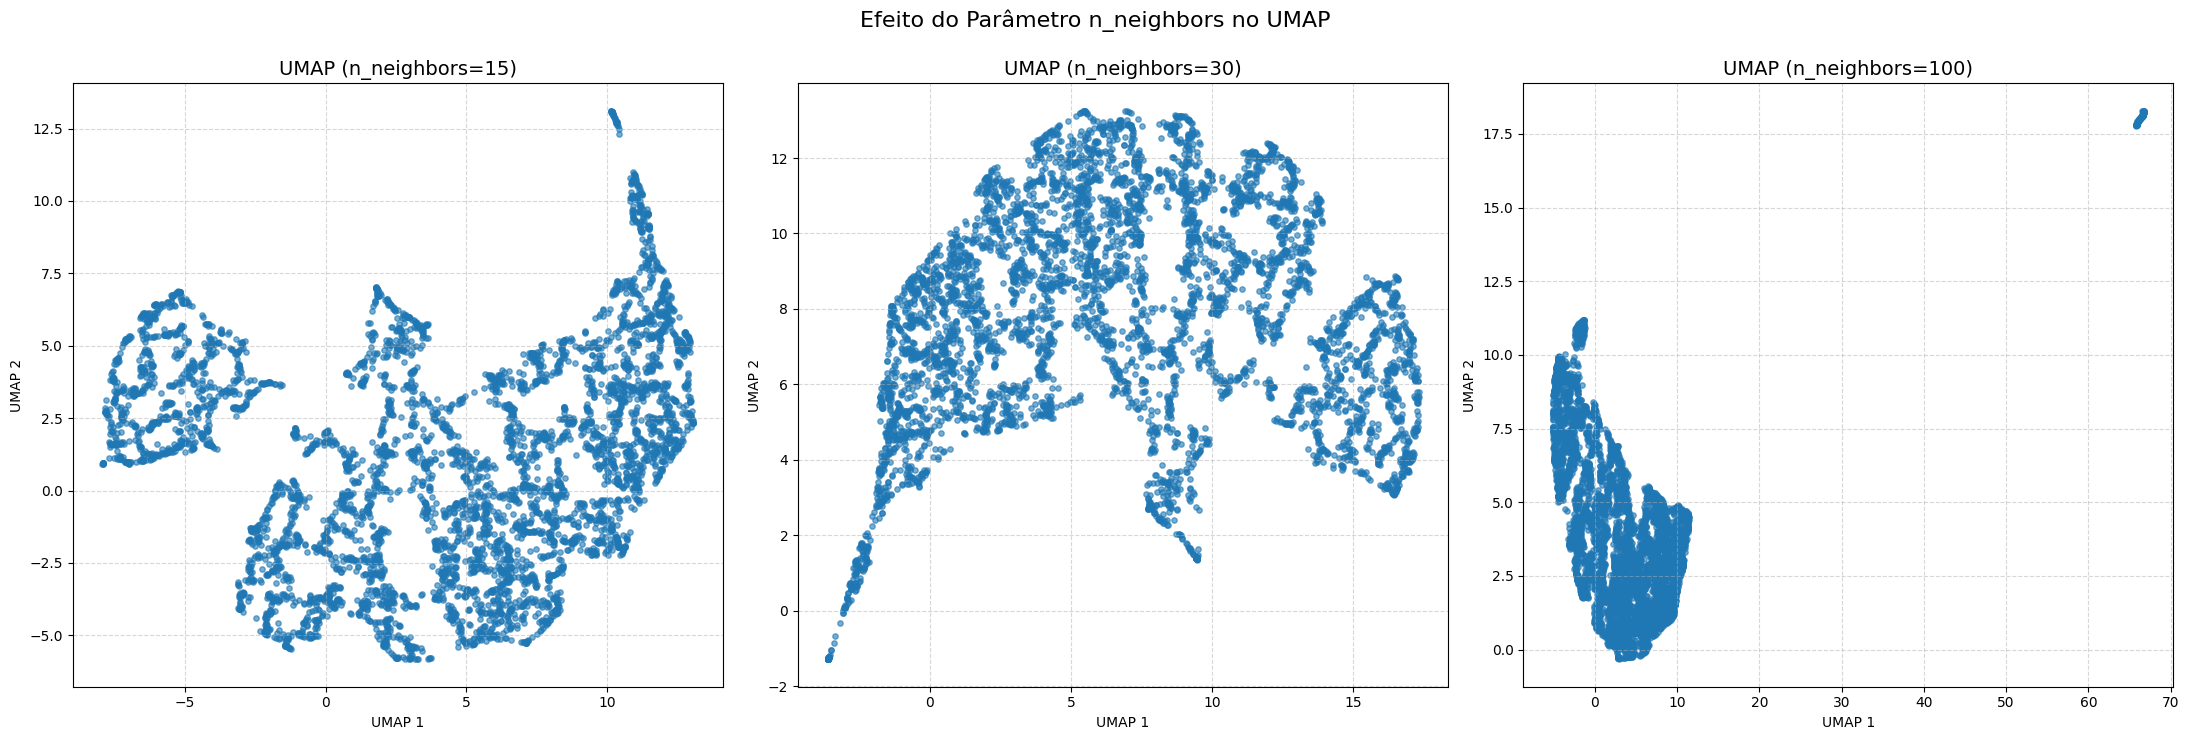

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

for i, n in enumerate(vizinhos):
    # Aplicando o UMAP
    reducer = umap.UMAP(n_neighbors=n, min_dist=0.1, random_state=42)
    df_umap = reducer.fit_transform(X_scaled)
    
    # Plotando no subplot correspondente
    scatter = axes[i].scatter(df_umap[:, 0], df_umap[:, 1], alpha=0.6, s=15, cmap='viridis')
    axes[i].set_title(f'UMAP (n_neighbors={n})', fontsize=14)
    axes[i].set_xlabel('UMAP 1')
    axes[i].set_ylabel('UMAP 2')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle('Efeito do Parâmetro n_neighbors no UMAP', fontsize=16, y=1.05)
plt.show()

In [ ]:
import umap
import plotly.graph_objects as go
from plotly.subplots import make_subplots

vizinhos = [5, 30, 100]

# Criando a estrutura de subplots 3D
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=[f'n_neighbors={n}' for n in vizinhos]
)

for i, n in enumerate(vizinhos):
    # IMPORTANTE: n_components=3 para gerar as 3 coordenadas
    reducer = umap.UMAP(n_neighbors=n, min_dist=0.1, n_components=3, random_state=42)
    X_umap_3d = reducer.fit_transform(X_scaled)
    
    # Adicionando o rastro (trace) de pontos ao subplot
    fig.add_trace(
        go.Scatter3d(
            x=X_umap_3d[:, 0],
            y=X_umap_3d[:, 1],
            z=X_umap_3d[:, 2],
            mode='markers',
            marker=dict(
                size=2,
                color=labels,
                colorscale='Viridis',
                opacity=0.6
            ),
            name=f'neighbors {n}'
        ),
        row=1, col=i+1
    )

fig.update_layout(
    title_text='Comparação UMAP 3D: Sensibilidade do n_neighbors',
    height=600,
    showlegend=False
)

fig.show()

# Gente, caso nao apareca no seu notebook, descomente a linha abaixo para abrir no navegador
# import plotly.io as pio
# pio.renderers.default = "browser"

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# K-means usando os dados do UMAP

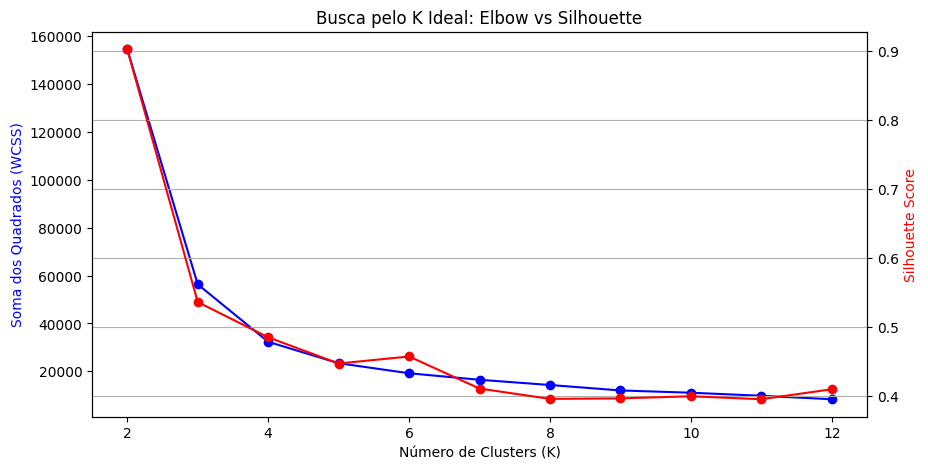

In [48]:
# Testando valores de K de 2 a 12
wcss = []
silhouette_values = []
K_range = range(2, 13)

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(df_umap) # Usamos os dados escalonados!
    
    wcss.append(kmeans.inertia_)
    silhouette_values.append(silhouette_score(df_umap, labels))

# Plotando os resultados
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(K_range, wcss, 'bo-', label='WCSS (Elbow)')
ax1.set_xlabel('Número de Clusters (K)')
ax1.set_ylabel('Soma dos Quadrados (WCSS)', color='b')

ax2 = ax1.twinx()
ax2.plot(K_range, silhouette_values, 'ro-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')

plt.title('Busca pelo K Ideal: Elbow vs Silhouette')
plt.grid()
plt.show()

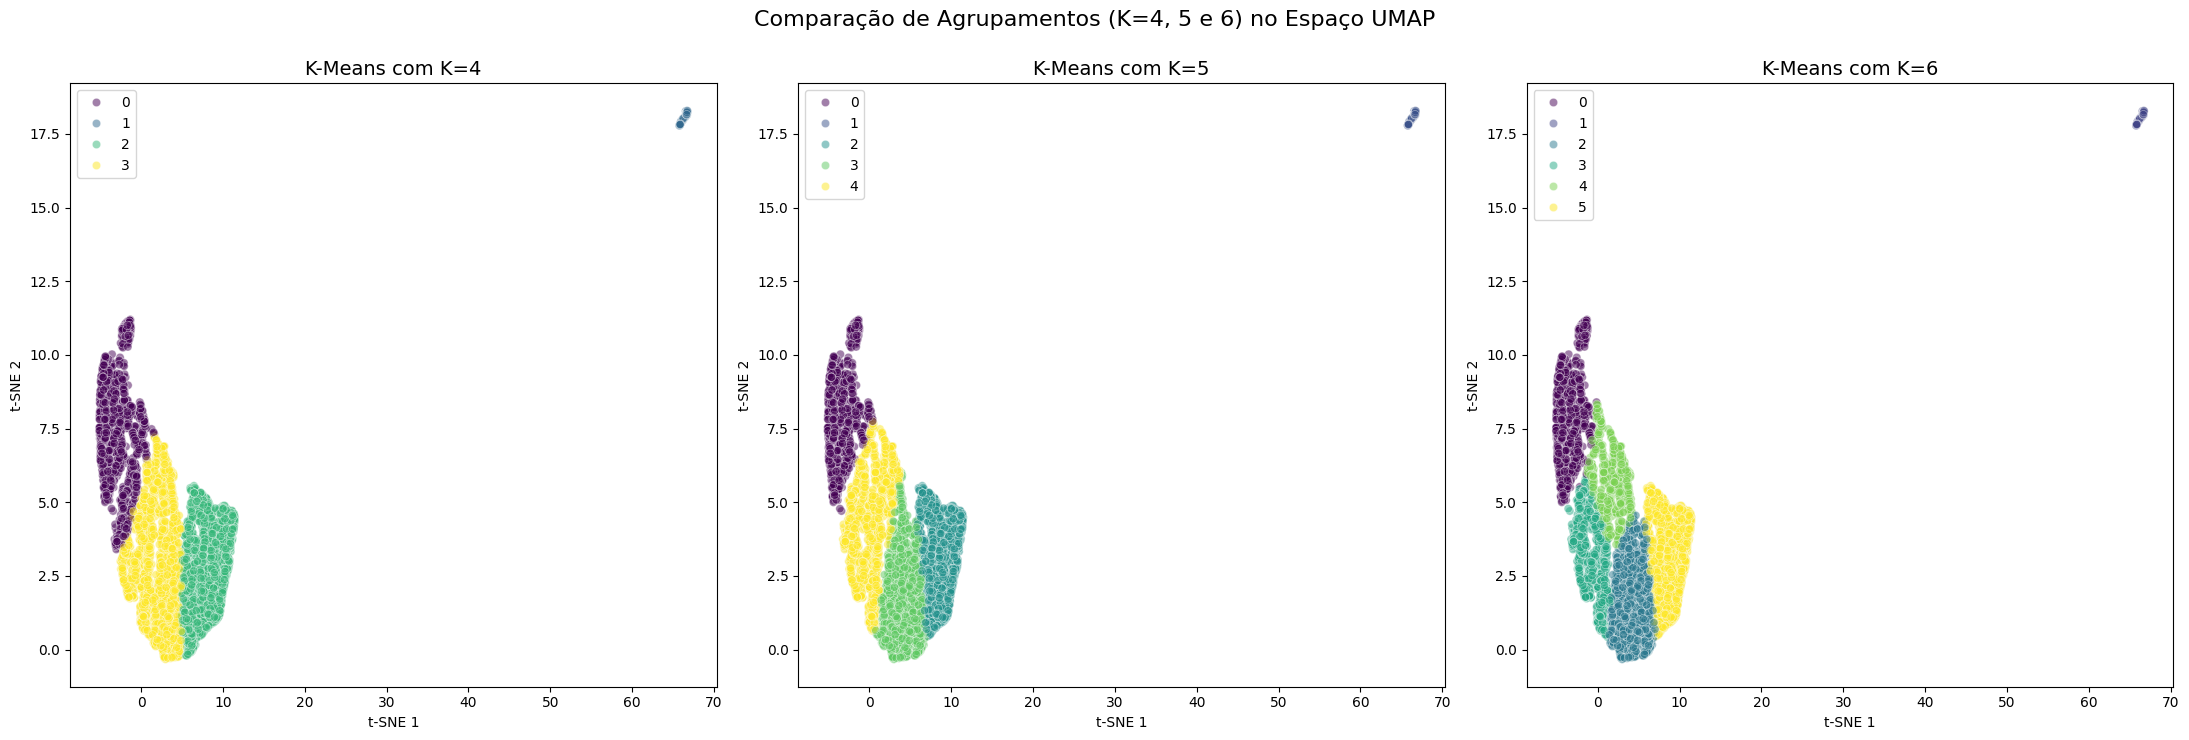

In [49]:
# Definindo os valores de K para comparar
lista_k = [4, 5, 6]

# Criando subplots para comparar lado a lado (melhor para o relatório)
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

for i, k in enumerate(lista_k):
    # 1. Executando o K-means com o 'k' da iteração atual
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(df_umap)

    # 2. Plotando em cada subplot
    sns.scatterplot(x=df_umap[:,0], y=df_umap[:,1], hue=labels, 
                    palette='viridis', ax=axes[i], legend='full', alpha=0.5)
    
    axes[i].set_title(f'K-Means com K={k}', fontsize=14)
    axes[i].set_xlabel('t-SNE 1')
    axes[i].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.suptitle('Comparação de Agrupamentos (K=4, 5 e 6) no Espaço UMAP', fontsize=16, y=1.05)
plt.show()

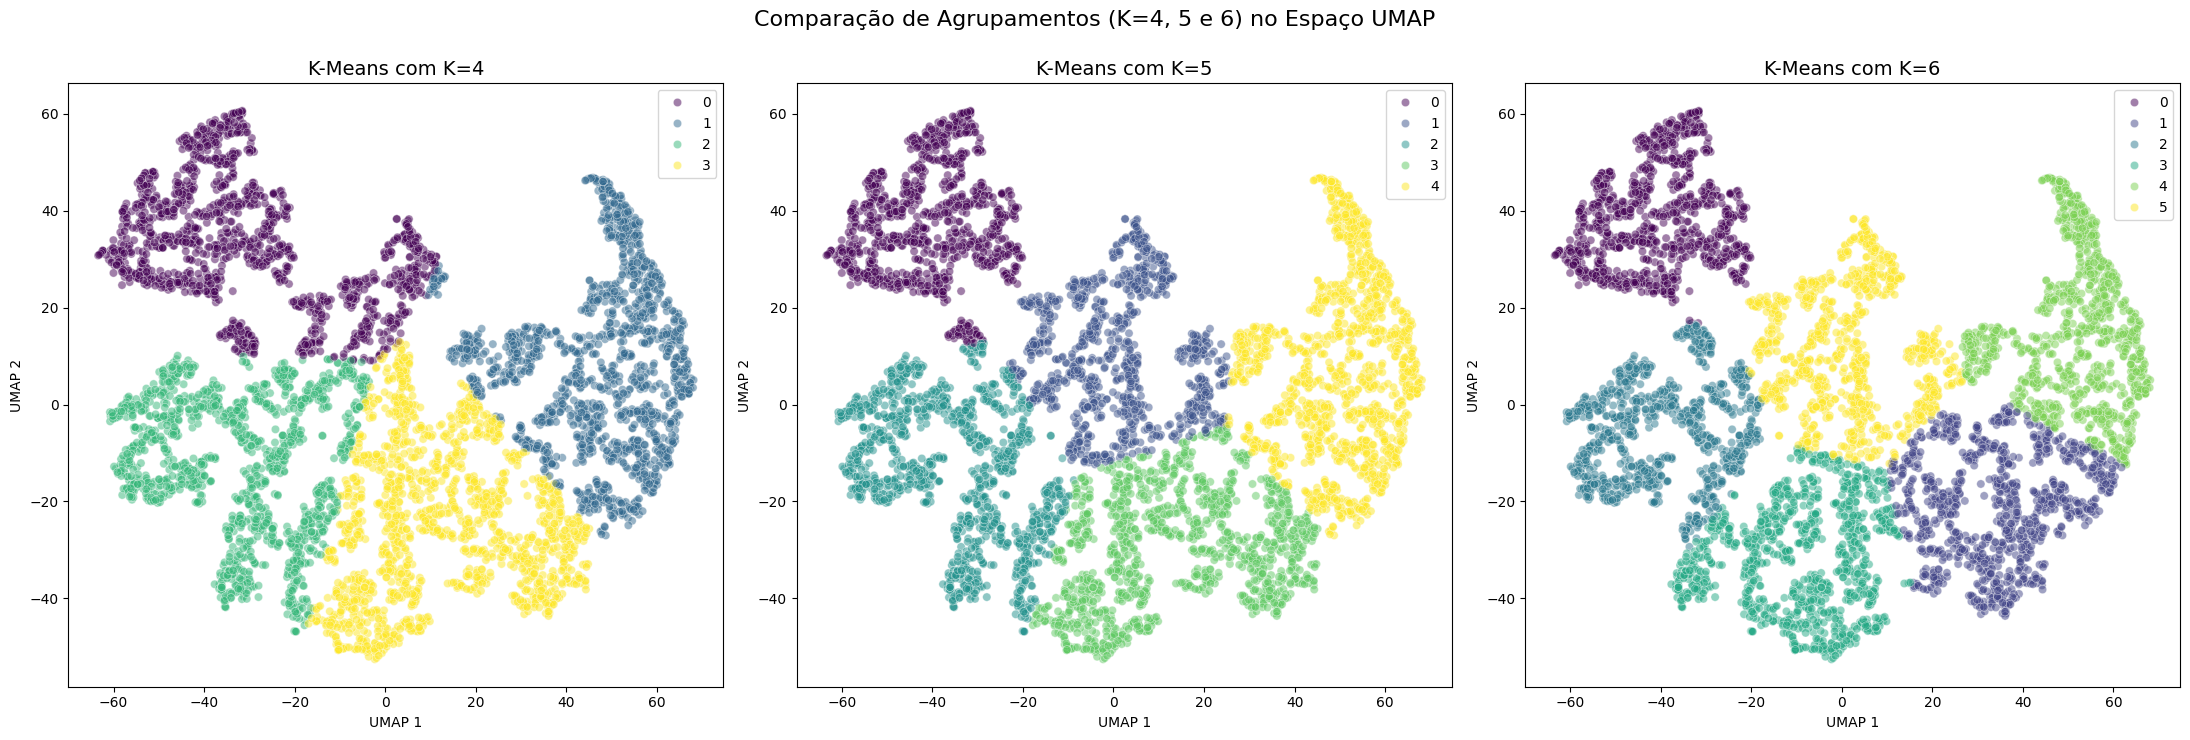

In [50]:
# Definindo os valores de K para comparar
lista_k = [4, 5, 6]

# Criando subplots para comparar lado a lado (melhor para o relatório)
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

for i, k in enumerate(lista_k):
    # 1. Executando o K-means com o 'k' da iteração atual
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(df_tsne)

    # 2. Plotando em cada subplot
    sns.scatterplot(x=df_tsne[:,0], y=df_tsne[:,1], hue=labels, 
                    palette='viridis', ax=axes[i], legend='full', alpha=0.5)
    
    axes[i].set_title(f'K-Means com K={k}', fontsize=14)
    axes[i].set_xlabel('UMAP 1')
    axes[i].set_ylabel('UMAP 2')

plt.tight_layout()
plt.suptitle('Comparação de Agrupamentos (K=4, 5 e 6) no Espaço UMAP', fontsize=16, y=1.05)
plt.show()

# DBSCAN

# Dedondograma